In [1]:
from ganrec_dataloader import * 
from utils import *   
from models import *
from skimage.transform import resize
import seaborn as sns

In [109]:

def forward_propagate(shape_x = None, shape_y = None, pad = None, energy_kev = None, detector_pixel_size = None, distance_sample_detector = None, phase_image = None, attenuation_image = None, fresnel_factor  = None, wavefield = None, distance = None, mode = 'reflect', value = 1, **kwargs):
    """
    mode: can be reflect, constant, circular
    If the phase and attenuation are provided, it uses them to create the wavefield. Otherwise, it uses the wavefield provided.
    this function propagates the wavefield from the sample to the detector. If fresnel_factor is not provided, it calculates it.

    You can use the **dataloader.kwargs() as an input to this function:
    """
    if 'phase' in kwargs.keys():
        phase_image = kwargs['phase']
    if 'attenuation' in kwargs.keys():
        attenuation_image = kwargs['attenuation']
    
    assert phase_image is not None or attenuation_image is not None, "phase_image and attenuation_image are not provided"
    if fresnel_factor is None:
        if distance is None:
            distance = distance_sample_detector
        fresnel_factor = ffactor(shape_x*pad, shape_y*pad, energy_kev, distance, detector_pixel_size) if type(distance) is not list else ffactors(shape_x*pad, shape_y*pad, energy_kev, distance, detector_pixel_size)
    # print("fresnel_factor shape", fresnel_factor.shape) if type(distance) is not list else print("fresnel_factor shape", fresnel_factor[0].shape)
    
    if wavefield is None:
        if phase_image is None and attenuation_image is None:
            assert 'phase_image' in kwargs.keys() and 'attenuation_image' in kwargs.keys(), "phase_image and attenuation_image are not provided"
            phase_image = phase_image
            attenuation_image = attenuation_image

        if type(phase_image) is not list:
            phase_image = [phase_image]
        if type(attenuation_image) is not list:
            attenuation_image = [attenuation_image]

        if type(phase_image) is list and type(phase_image[0]) is torch.Tensor and len(phase_image[0].shape) == 4:
            phase_image = torch.stack(phase_image)
            attenuation_image = torch.stack(attenuation_image)
            #squeeze the first dimension
            if len(phase_image.shape) == 5:
                phase_image = phase_image.squeeze(0)
                attenuation_image = attenuation_image.squeeze(0)
        else:
            phase_image = torch_reshape(phase_image)
            attenuation_image = torch_reshape(attenuation_image)
        
        fresnel_factor = torch_reshape(fresnel_factor, complex = True)
                
        # print("phase_image shape, attenuation_image shape, fresnel_factor shape", phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
    
        odd_case = False
        px, py = phase_image.shape[2], phase_image.shape[3]
        if py % 2 != 0:
            phase_image = F.pad(phase_image, (0, 1, 0, 0), mode, value)
            attenuation_image = F.pad(attenuation_image, (0, 1, 0, 0), mode, value)
            odd_case = True
        if px % 2 != 0:
            phase_image = F.pad(phase_image, (0, 0, 0, 1), mode, value)
            attenuation_image = F.pad(attenuation_image, (0, 0, 0, 1),mode, value)
            odd_case = True
        if odd_case:
            new_px, new_py = phase_image.shape[2], phase_image.shape[3]
            if distance is None:
                distance = distance_sample_detector
            fresnel_factor = torch_reshape(ffactor(new_px*pad, new_py*pad, energy_kev, distance, detector_pixel_size), complex = True) if type(distance) is not list else torch_reshape(ffactors(new_px*pad, new_py*pad, energy_kev, distance, detector_pixel_size), complex = True)
            print("odd case", px, py, phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
        
        # print("phase_image shape, attenuation_image shape, fresnel_factor shape", phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
        
        
        #pad the phase and attenuation image to the same size as fresnel_factor by adding ones to the end of the image
        if type(fresnel_factor) is not list and fresnel_factor.shape != phase_image.shape or type(fresnel_factor) is list and fresnel_factor[0].shape != phase_image.shape:
            if mode == 'constant':
                if value == 'mean':
                    phase_value = tensor_to_np(torch.mean(phase_image)).item()
                    attenuation_value = tensor_to_np(torch.mean(attenuation_image)).item()
                elif value == 'min':
                    phase_value = tensor_to_np(torch.min(phase_image)).item()
                    attenuation_value = tensor_to_np(torch.min(attenuation_image)).item()
                elif value == 'max':
                    phase_value = np.max(tensor_to_np(phase_image)).item()
                    attenuation_value = np.max(tensor_to_np(attenuation_image)).item()
                else:
                    phase_value = value
                    attenuation_value = value

                phase_image = F.pad(phase_image, (int((fresnel_factor.shape[3] - phase_image.shape[3])/2), int((fresnel_factor.shape[3] - phase_image.shape[3])/2), int((fresnel_factor.shape[2] - phase_image.shape[2])/2), int((fresnel_factor.shape[2] - phase_image.shape[2])/2)), mode = mode, value = phase_value)
                attenuation_image = F.pad(attenuation_image, (int((fresnel_factor.shape[3] - attenuation_image.shape[3])/2), int((fresnel_factor.shape[3] - attenuation_image.shape[3])/2), int((fresnel_factor.shape[2] - attenuation_image.shape[2])/2), int((fresnel_factor.shape[2] - attenuation_image.shape[2])/2)), mode = mode, value = attenuation_value)
            else:
                phase_image = F.pad(phase_image, (int((fresnel_factor.shape[3] - phase_image.shape[3])/2), int((fresnel_factor.shape[3] - phase_image.shape[3])/2), int((fresnel_factor.shape[2] - phase_image.shape[2])/2), int((fresnel_factor.shape[2] - phase_image.shape[2])/2)), mode)
                attenuation_image = F.pad(attenuation_image, (int((fresnel_factor.shape[3] - attenuation_image.shape[3])/2), int((fresnel_factor.shape[3] - attenuation_image.shape[3])/2), int((fresnel_factor.shape[2] - attenuation_image.shape[2])/2), int((fresnel_factor.shape[2] - attenuation_image.shape[2])/2)), mode)
        # print("phase_image shape, attenuation_image shape, fresnel_factor shape", phase_image.shape, attenuation_image.shape, fresnel_factor.shape)
        wavefield = torch.exp(torch.complex(-attenuation_image, phase_image))
    
    else:
        wavefield = torch_reshape(wavefield, complex = True)
        fresnel_factor = torch_reshape(fresnel_factor, complex = True)
        px, py = fresnel_factor.shape[2], fresnel_factor.shape[3]
    # visualize([tensor_to_np(phase_image)])
    I = (torch.abs(torch.fft.ifft2(fresnel_factor * torch.fft.fft2(wavefield)))**2)
    I = I[:, :, int((I.shape[2] - shape_x)/2):int((I.shape[2] + shape_x)/2), int((I.shape[3] - shape_y)/2):int((I.shape[3] + shape_y)/2)]
    I = torch_reshape(I)
    return I
   
   
def get_all_info(path = None, images = None, idx = None, energy_kev = None, detector_pixel_size =None, distance_sample_detector = None, alpha = 1e-8, delta_beta = 1e1, pad = 2, method = 'TIE', file_type = 'tif', image = None, **kwargs):
    """
    make sure that the unit of energy is in keV, the unit of detector_pixel_size is in meter, and the unit of distance_sample_detector is in meter
    """
    if idx is not None and type(idx) is not list:
        idx = [idx]
    
    if images is not None:
        image = [images[i] for i in idx]
    
    if 'image_path' in kwargs.keys():
        image_path = kwargs['image_path']
    else:
        image_path = None

    if 'phase' in kwargs.keys():
        phase = kwargs['phase']
        attenuation = kwargs['attenuation']
    elif 'phase_image' in kwargs.keys():
        phase = kwargs['phase_image']
        attenuation = kwargs['attenuation_image']
    else:
        phase = None
        attenuation = None

    if 'z' in kwargs.keys():
        distance_sample_detector = kwargs['z']
    if 'pv' in kwargs.keys():
        detector_pixel_size = kwargs['pv']
    if 'energy' in kwargs.keys():
        energy_kev = kwargs['energy']

    if 'mode' in kwargs.keys():
        mode = kwargs['mode']
    else:
        mode = 'reflect'
    if 'value' in kwargs.keys():
        value = kwargs['value']
    else:
        value = 'mean'

    

    if type(distance_sample_detector) is list:
        distance_sample_detector = [distance_sample_detector[i] for i in idx] if idx is not None else distance_sample_detector
    if type(detector_pixel_size) is list:
        detector_pixel_size = [detector_pixel_size[i] for i in idx] if idx is not None else detector_pixel_size
        assert len(detector_pixel_size) == len(distance_sample_detector), "detector_pixel_size and distance_sample_detector must have the same length"
    if type(energy_kev) is list:
        energy_kev = [energy_kev[i] for i in idx] if idx is not None else energy_kev
    if type(pad) is list:
        pad = [pad[i] for i in idx] if idx is not None else pad
    lam = wavelength_from_energy(energy_kev).magnitude
    if 'fresnel_number' in kwargs.keys():
        fresnel_number = kwargs['fresnel_number']
    else:
        fresnel_number = [fresnel_calculator(energy_kev, lam, detector_pixel_size, distance) for distance in distance_sample_detector] if type(distance_sample_detector) is list else fresnel_calculator(energy_kev, lam, detector_pixel_size, distance_sample_detector)
    if 'fresnel_factor' in kwargs.keys():
        fresnel_factor = kwargs['fresnel_factor']
    else:
        fresnel_factor = None
    if path is not None:
        #if path is a folder
        if type(path) is str and os.path.isdir(path):
            images = list(io.imread_collection(path + '/*.' + file_type).files)
            image_path = [images[i] for i in idx]
            image = load_images_parallel(image_path)
        #if path is a list of files
        elif type(path) is list and not os.path.isfile(path[0]):
            image_path = [path[i] for i in idx]
            image = load_images_parallel(image_path)
        elif type(path) is list and os.path.isdir(path[0]):
            folders = path
            images = []
            for folder in folders:
                images += list(io.imread_collection(folder + '/*.' + file_type).files)
            image_path = [images[i] for i in idx]
            image = load_images_parallel(image_path)
        elif type(path) is np.array:
            image_path = os.getcwd()
            images = path
            image = [images[i] for i in idx]
        else:
            image = [path[i] for i in idx]
            try:
                image = load_images_parallel(image)
            except:
                pass
                
    else:
        assert phase is not None and attenuation is not None, "phase and attenuation must be given"
        attenuation = attenuation
        # from ganrec_dataloader import forward_propagate, tensor_to_np
        shape_x, shape_y = phase.shape
        fresnel_factor = ffactors(shape_x*pad, shape_y*pad, energy_kev, distance_sample_detector, detector_pixel_size)
        if type(distance_sample_detector) == list:
            image = [tensor_to_np(forward_propagate(shape_x=shape_x,shape_y=shape_y, pad=pad, energy_kev=energy_kev, detector_pixel_size=detector_pixel_size, distance_sample_detector=distance, phase_image=phase, attenuation_image=attenuation, fresnel_factor=fresnel_factor[i], wavefield=None, distance=distance, mode=mode, value=value)) for i, distance in enumerate(distance_sample_detector)]
        else:    
            image = tensor_to_np(forward_propagate(shape_x=shape_x, shape_y=shape_y, pad=pad, energy_kev=energy_kev, detector_pixel_size=detector_pixel_size, distance_sample_detector=distance_sample_detector, phase_image=phase, attenuation_image=attenuation, fresnel_factor=fresnel_factor, wavefield=None, distance=distance_sample_detector, mode=mode, value=value))
    if image is not None: 
        if type(image) is list:
            ND = len(image)
            if len(image[0].shape) == 2:
                shape_x, shape_y = image[0].shape
                Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
                ND = 1
                image_path = os.getcwd()
            else:
                shape_x, shape_y = image[0].shape[1:]
                Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
        else:
            ND = 1
            shape_x, shape_y = image.shape
            Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
        if image_path is None:
            image_path = os.getcwd()
        if images is None:
            images = image

        if 'correct' in kwargs.keys():
            if kwargs['correct'] == True:
                if 'mean_dark_image' and 'mean_ref_image' in kwargs.keys():
                    mean_dark_image = kwargs['mean_dark_image']
                    mean_ref_image = kwargs['mean_ref_image']
                else: 
                    all_images = list(io.imread_collection(path + '/*.' + file_type).files)
                    mean_ref_image = np.mean(io.imread_collection([im_name for im_name in all_images if 'ref' in im_name]), axis = 0)
                    mean_dark_image = np.mean(io.imread_collection([im_name for im_name in all_images if 'dar' in im_name]), axis = 0)
                    
                if len(image) > 1:
                    image = [(image[i] - mean_dark_image) / (mean_ref_image - mean_dark_image) for i in range(len(image))]
                else:
                    image = (image - mean_dark_image) / (mean_ref_image - mean_dark_image)
        if fresnel_factor is None:
            fresnel_factor = ffactors(shape_x*pad, shape_y*pad, energy_kev, distance_sample_detector, detector_pixel_size)
        kwargs = {
            "path": path,
            "output_path" : os.getcwd(),
            "idx": idx,
            "column_name": 'path',
            "energy_J": energy_kev_to_joule(energy_kev),
            "energy_kev": energy_kev,
            "lam": lam,
            "detector_pixel_size": detector_pixel_size,
            "distance_sample_detector": distance_sample_detector,
            "fresnel_number": fresnel_number,
            "wave_number": wave_number(energy_kev),

            "shape_x": shape_x,
            "px": shape_x,
            "shape_y": shape_y,
            "py": shape_y,
            "pad_mode": mode,
            'shape': [int(shape_x), int(shape_y)],
            'distance': [distance_sample_detector],
            'z': distance_sample_detector,
            
            'energy': energy_kev, 
            'alpha': alpha, 
            'pad': pad,
            'nfx': int(shape_x) * pad, 
            'nfy': int(shape_y) * pad,
            'pv': detector_pixel_size,
            'pixel_size': [detector_pixel_size, detector_pixel_size],
            'sample_frequency': [1.0/detector_pixel_size, 1.0/detector_pixel_size],
            'fx': Fx, 'fy': Fy,
            'method': method, 
            'delta_beta': delta_beta,
            "fresnel_factor":  fresnel_factor,
            "i_input": image[0],
            "image_path": image_path,
            "image": image,
            "all_images": images,
            "ND": ND,
            "fresnel_factor": fresnel_factor,
            "phase": phase,
            "attenuation": attenuation,
        } 
        kwargs.update(save_path_generator(**kwargs))
        return kwargs

    else:
        
        assert path is not None
        if type(path) is str:
            assert os.path.exists(path), "path does not exist"
            if os.path.isdir(path):
                images = list(io.imread_collection(path + '/*.' + file_type).files)
                image_path = [images[i] for i in idx]
                image = load_images_parallel(image_path)
            else:
                images = list(path)
                image = load_image(path)
            get_all_info(image=image, **kwargs)
        elif type(path) is list:
            path = [path[i] for i in idx]
            if type(path[0]) is str:
                #if the path[0] is a folder
                if os.path.isdir(path[0]):
                    images = list(io.imread_collection(path + '/*.' + file_type).files)
                    image_path = [images[i] for i in idx]
                else:
                    image_path = path
                image = load_images_parallel(image_path)
            else:
                image = [path[i] for i in idx]
            get_all_info(image=image, **kwargs)
        else:
            images = path
            image = [images[i] for i in idx]
            get_all_info(image=image, **kwargs)
  
class Ganrec_Dataloader(torch.utils.data.Dataset):
    """
    The dataloader takes the different arguements and arranges it in a way that it can be used for the training and other purposes.
    ********************************
    Transform_type can be: 'reshape', 'normalize', 'contrast', 'contrast_normalize', 'brightness', 'norm'
    The image is then saved in the transformed_images variable. This will be used for the training.

    If there are multiple images, the idx variable is used to choose the image. 
    Batch_size is the number of images in the batch, which can be used for the training. 
    The batch_images variable is used to get the batch of images. The idx_batches variable is used to get the
    
    get_all_info() is used to get the information about the image and the fresnel factor.

    If phase and attenuation are provided, the forward propagation is done and saved in the propagated_forward variable.
    The fresnel factor is also saved in the fresnel_factor variable.
    ********************************
    """
    def __init__(self,**kwargs):
        self.kwargs = get_args()
        self.kwargs.update(kwargs)
        
        self.kwargs.update(get_all_info(**kwargs))
        if 'phase' not in self.kwargs.keys() and 'attenuation' not in self.kwargs.keys():
            kwargs['phase'] = None
            kwargs['attenuation'] = None
        keys = self.kwargs.keys()
        [self.__setattr__(key, self.kwargs[key]) for key in keys]
        self.dims = (self.ND, self.shape_x, self.shape_y)
        self.transformed_images = transform(self.image, self.kwargs['transform_type'], self.kwargs['transform_factor'])
        self.kwargs['transform_type'] = self.transform_type
        self.kwargs['transform_factor'] = self.transform_factor
        self.kwargs['transformed_images'] = self.transformed_images
        self.batch_size = self.transformed_images.shape[0]
        super(Ganrec_Dataloader, self).__init__()
        if 'mode' in self.kwargs.keys():
            self.mode = self.kwargs['mode']
        else:
            self.mode = 'reflect'
        if 'value' in self.kwargs.keys():
            self.value = self.kwargs['value']

    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx = None, transform_type = None): 
            
        if idx is not None:
            kwargs = self.kwargs
            if transform_type is not None:
                kwargs['transform_type'] = transform_type
            kwargs["idx"] = idx
            new = Ganrec_Dataloader(**kwargs)
            return new.transformed_images
        else:
            return self.transformed_images
    
    def __getbatchimages__(self, batch_size = None, transform_type = None):
        """
        Returns a batch of transformed images:
        ********************************
        batch_images, idx_batches = dataloader.__getbatchimages__(batch_size = 100, transform_type = 'reshape')
        for i, image in enumerate(batch_images):
            print(image.shape)
        ********************************
        """
        if batch_size is None:
            batch_size = self.batch_size
        if transform_type is None:
            transform_type = self.kwargs['transform_type']
        all_images = self.all_images
        n = len(all_images)
        seed = self.seed
        import random
        random.seed(seed)
        all_idx = list(range(n))
        random.shuffle(all_idx)
        idx_batches = [all_idx[i:i + batch_size] for i in range(0, n, batch_size)]
        batch_images = []
        from joblib import Parallel, delayed
        n_jobs = max(30, len(idx_batches))
        batch_images = Parallel(n_jobs=n_jobs)(delayed(self.__getitem__)(idx, transform_type) for idx in idx_batches)
        return batch_images, idx_batches
    
    def update_values(self, change_all = False, **info):
        """
        This function is used to update the values of the dataloader. 
        If the change is a shouldn't affect values from the get_all_info() function, then change_all should be False.
        Otherwise, it should be True.
        """

        if change_all:
            kwargs = self.kwargs
            kwargs.update(info)
            kwargs.update(get_all_info(**kwargs))
            [self.__setattr__(key, kwargs[key]) for key in kwargs.keys()]
            self.transformed_images = transform(self.image, kwargs['transform_type'], kwargs['transform_factor'])
            self.dims = (self.ND, self.shape_x, self.shape_y)
            print(self.kwargs['transform_type'])
        else:
            kwargs = self.kwargs
            kwargs.update(info)
            [self.__setattr__(key, info[key]) for key in info.keys()]
            # if 'transform_type' in info.keys() or 'transform_factor' in info.keys():
            #     self.transformed_images = transform(self.image, self.kwargs['transform_type'], self.kwargs['transform_factor'])
            #     self.dims = (self.ND, self.shape_x, self.shape_y)
            #     print(self.kwargs['transform_type'])
        
        return self
            
    def normalize(self, idx = None, transform_type = None):
        image = self.__getitem__(idx, transform_type)
        # image = torchnor_phase(image)
        return image
    
    def get_kwargs(self):
        return self.__dict__
    
    def visualize(self, idx = None, show_or_plot = 'show', tranformed = False):
        if idx is not None:
            kwargs = self.kwargs
            kwargs["idx"] = idx
            new = Ganrec_Dataloader(**kwargs)
        else:
            new = self
        if tranformed:
            images = new.transformed_images
            try:
                images = images[:,0,:,:].detach().cpu().numpy()
            except:
                images = images[0,:,:].numpy()
        else:
            images = new.image

        if type(images) is not list:
            # images = [images]
            images = list(images)
        fig = visualize(images, show_or_plot = show_or_plot)
        return fig
    
    def forward_propagate(self, distance = None):
        distance = self.distance_sample_detector if distance is None else distance
        wavefield = None if 'wavefield' not in self.kwargs.keys() else self.kwargs['wavefield']

        if type(distance) is not list:
            self.propagated_forward = forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = distance, phase_image = self.phase, attenuation_image = self.attenuation, fresnel_factor  = self.fresnel_factor, wavefield = wavefield, distance = distance, mode = self.mode, value = self.value)
        else:
            propagated_forward = [forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = distance[i], phase_image = self.phase, attenuation_image = self.attenuation, fresnel_factor  = None, wavefield = wavefield, distance = distance[i], mode=self.mode, value=self.value) for i in range(len(distance))]
            self.propagated_forward = torch.stack(propagated_forward, dim = 0)[:,0,:,:,:]
            print(self.propagated_forward.shape)
        return self.propagated_forward


# Load simulation files and define the different properties used

In [3]:
import quantities as pq
simulation_attenuation = '//beegfs/desy/user/jentscht/for_dawit/iterations_1/groundtruth/heterogenous_energy_30_keV_geometrical_objects_lithium_hybride_30000_eV/ground_truth_projection/ground_truth_projection_attenuation_30000_eV_00077_type_float32_16384x16384.tif'
simulation_phase = '//beegfs/desy/user/jentscht/for_dawit/iterations_1/groundtruth/heterogenous_energy_30_keV_geometrical_objects_lithium_hybride_30000_eV/ground_truth_projection/ground_truth_projection_phase_30000_eV_00077_type_float32_16384x16384.tif'

energy = 30.8 * pq.keV
lam = wavelength_from_energy(energy)
fresnel_number = 0.005 * pq.dimensionless
z = 1.0 * pq.meter
pv = np.sqrt(fresnel_number * lam * z) #array(8.39314161e-06) * m

phase_image_orig = resize(io.imread(simulation_phase), (512, 512)) * 2 * np.pi / lam.magnitude
attenuation_image_orig = resize(io.imread(simulation_attenuation), (512, 512)) * 2*np.pi / lam.magnitude

phase_image = nor_phase(phase_image_orig)/np.max(nor_phase(phase_image_orig))
attenuation_image = nor_phase(attenuation_image_orig)/np.max(nor_phase(attenuation_image_orig))

px, py = phase_image.shape

given_phase = phase_image
cos, sin = np.cos(given_phase), np.sin(given_phase)
given_absorption = (attenuation_image)
given_absorption = resize(given_absorption, (px, py))


# Propagate to different distances


rows:  1 cols:  3


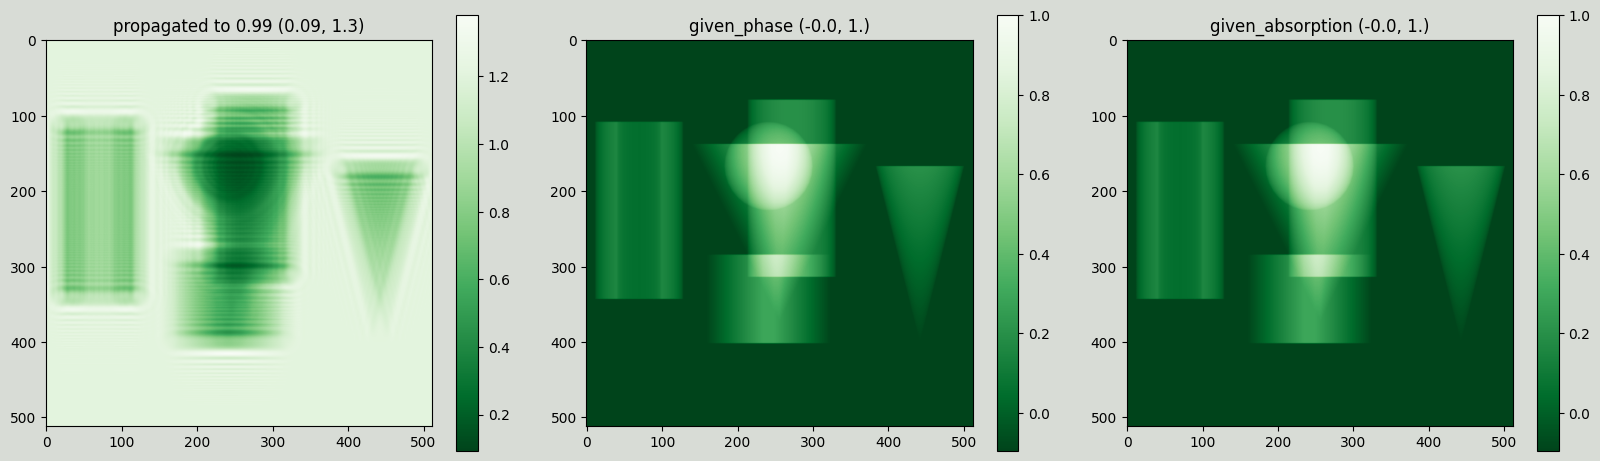

In [4]:
different_distances = list(np.arange(0, z.magnitude, 0.03))
ffs = ffactors(px * 2, py *2, energy.magnitude, different_distances, pv.magnitude)
propagated_images = [transform(forward_propagate(shape_x = px, shape_y = py, pad = 2, energy_kev = energy.magnitude, detector_pixel_size = pv.magnitude, distance_sample_detector = distance, phase_image = given_phase, attenuation_image = given_absorption, fresnel_factor  = ff, wavefield = None, distance =  distance, mode = 'reflect', value = 'mean'), 'reshape') for ff, distance in zip(ffs, different_distances)]
z_id = -1
fig = visualize([tensor_to_np(propagated_images[z_id]), given_phase, given_absorption], title=['propagated to '+str(different_distances[z_id]), 'given_phase', 'given_absorption'], cmap = 'Greens_r')

rows:  1 cols:  4


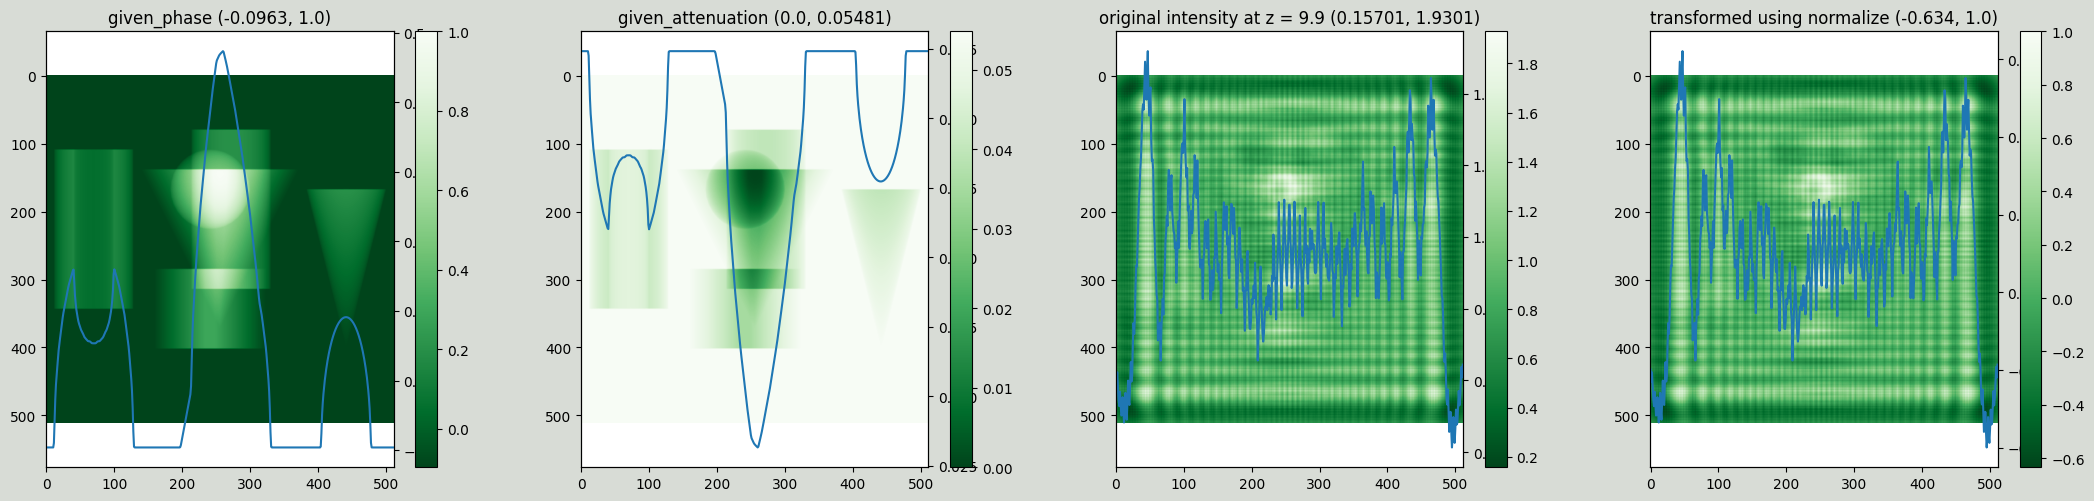

In [86]:
abs_ratio = 0.05
info = {
    'exp_name': 'heterogenous data',
    'phase': given_phase,
    'attenuation': (1 - given_absorption)*abs_ratio,
    'pv': pv.magnitude,
    'wavenumber': 2 * np.pi / lam.magnitude,
    'distance_sample_detector': z.magnitude,
    'fresnel_number': fresnel_number.magnitude,
    'lam': lam.magnitude,
    'energy_kev': energy.magnitude,
    'z': different_distances[z_id]*10,
    'pad':2,
    'idx': list(np.arange(0, len(different_distances), len(different_distances)//6)),
    'transform_factor': 0.7,
    'transform_type': 'normalize',
    'mode': 'constant',
    'value': 'max',
    'abs_ratio':abs_ratio,
}
dataloader = Ganrec_Dataloader(**info)
forwarded = dataloader.forward_propagate()
fig = visualize([dataloader.phase, dataloader.attenuation, dataloader.image, tensor_to_np(dataloader.transformed_images)], title = ['given_phase', 'given_attenuation', 'original intensity at z = '+str(different_distances[z_id]*10), 'transformed using '+str(dataloader.transform_type)], cmap='Greens_r', show_or_plot='both')

rows:  1 cols:  4


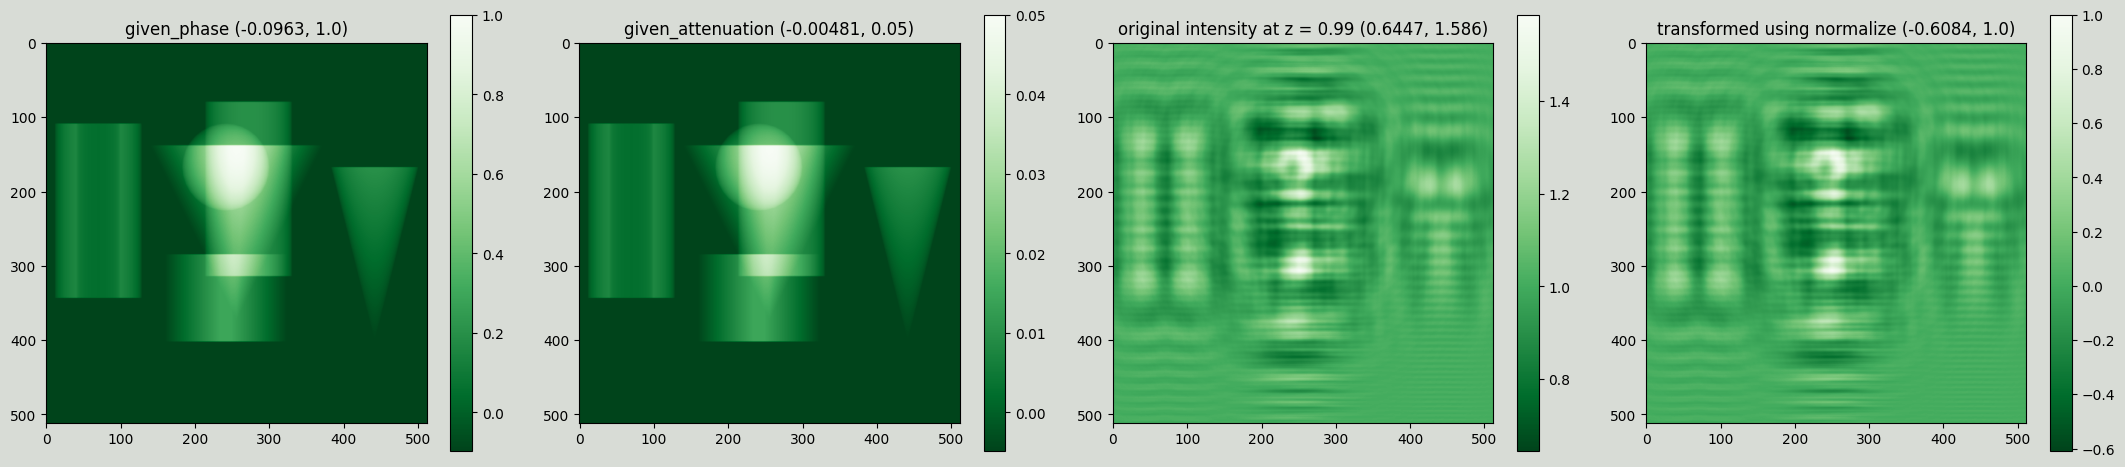

In [47]:
info = {
    'exp_name': 'heterogenous data',
    'phase': given_phase,
    'attenuation': given_absorption,
    'pv': pv.magnitude,
    'wavenumber': 2 * np.pi / lam.magnitude,
    'distance_sample_detector': z.magnitude,
    'fresnel_number': fresnel_number.magnitude,
    'lam': lam.magnitude,
    'energy_kev': energy.magnitude,
    'z': different_distances[z_id]*10,
    'pad':2,
    'idx': list(np.arange(0, len(different_distances), len(different_distances)//6)),
    'transform_factor': 0.7,
    'transform_type': 'normalize',
    'mode': 'constant',
    'value':'min',
    'abs_ratio': 0.05,
}
dataloader = Ganrec_Dataloader(**info)
fig = visualize([dataloader.phase, dataloader.attenuation, dataloader.image, tensor_to_np(dataloader.transformed_images)], title = ['given_phase', 'given_attenuation', 'original intensity at z = '+str(different_distances[z_id]), 'transformed using '+str(dataloader.transform_type)], cmap='Greens_r')

# This can also be done simply using the dataloader class

rows:  1 cols:  4


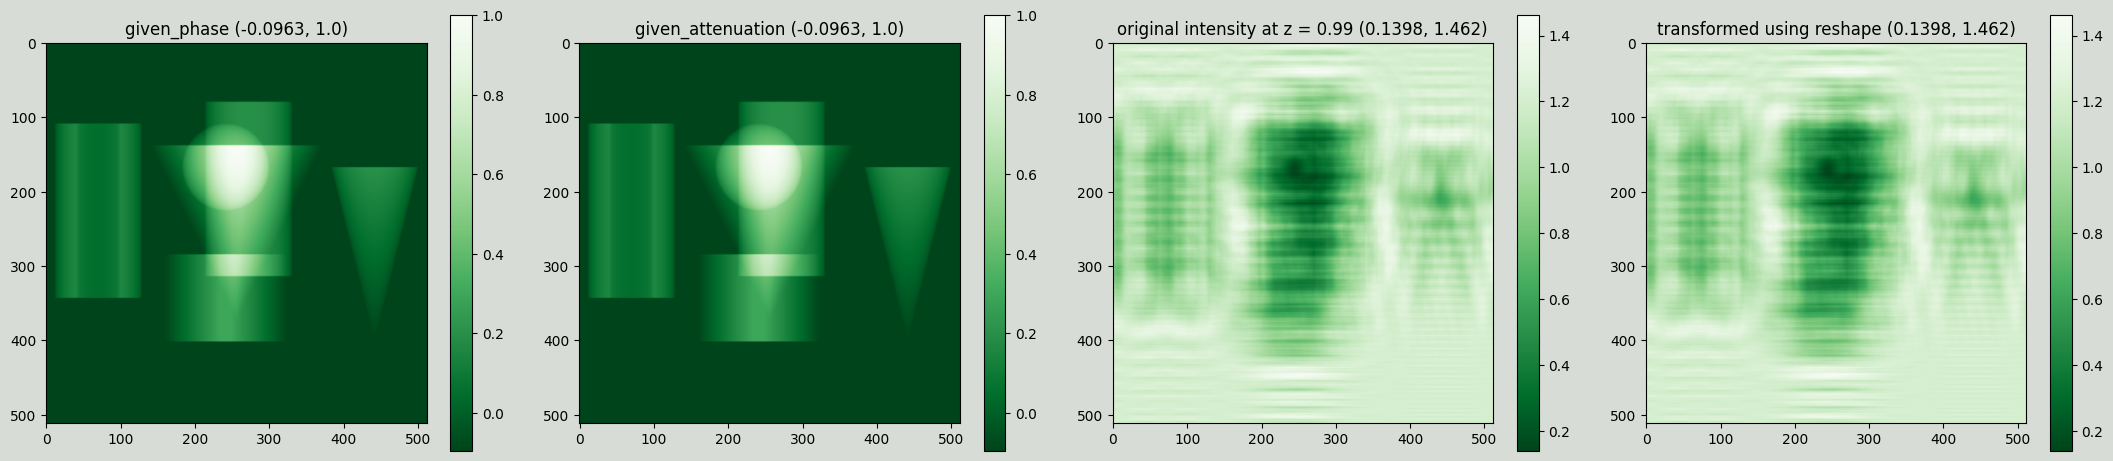

In [110]:
info = {
    'exp_name': 'heterogenous data',
    'phase': given_phase,
    'attenuation': given_absorption,
    'pv': pv.magnitude,
    'wavenumber': 2 * np.pi / lam.magnitude,
    'distance_sample_detector': z.magnitude,
    'fresnel_number': fresnel_number.magnitude,
    'lam': lam.magnitude,
    'energy_kev': energy.magnitude,
    'z': different_distances[z_id]*10,
    'pad':2,
    'idx': list(np.arange(0, len(different_distances), len(different_distances)//6)),
    'transform_factor': 0.7,
    'transform_type': 'reshape',
    'mode': 'reflect',
    'value': 'mean',
    'abs_ratio': 0.05,
}
dataloader = Ganrec_Dataloader(**info)
fig = visualize([dataloader.phase, dataloader.attenuation, dataloader.image, tensor_to_np(dataloader.transformed_images)], title = ['given_phase', 'given_attenuation', 'original intensity at z = '+str(different_distances[z_id]), 'transformed using '+str(dataloader.transform_type)], cmap='Greens_r')

In [168]:
class make_ganrec_model(nn.Module):
    def __init__(self, shape_x, shape_y, conv_num, conv_size, dropout, output_num, fresnel_factor, transformed_images=None, device=None, **kwargs):
        super(make_ganrec_model, self).__init__()
        for key, value in kwargs.items():
            setattr(self, key, value)
        self.device = device
        if self.device is None:
            self.device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")
        
        self.fresnel_factor = to_device(torch_reshape(fresnel_factor, complex=True), self.device)
        self.transformed_images = to_device(transformed_images, self.device)
        self.image = to_device(self.image, self.device)
        self.shape_x = shape_x
        self.shape_y = shape_y
        self.conv_num = conv_num
        self.conv_size = conv_size
        self.dropout = dropout
        self.output_num = output_num
        self.units = 128
        self.fc_size = shape_x * shape_y
        if 'mode' in kwargs.keys():
            self.mode = kwargs['mode']
        else:
            self.mode = 'constant'
        if 'value' in kwargs.keys():
            self.value = kwargs['value']
        else:
            self.value = 'mean'
        if 'abs_ratio' in kwargs.keys():
            self.abs_ratio = kwargs['abs_ratio']
        else:
            self.abs_ratio = 1
        ##################################################################################################
        # We first define the generator model
        ##################################################################################################
        
        self.fc_stack = nn.ModuleList([
            dense_layer(in_features=self.units, out_features=self.units, dropout=self.dropout),
            dense_layer(in_features=self.units, out_features=self.units, dropout=self.dropout),
            dense_layer(in_features=self.units, out_features=self.units, dropout=self.dropout),
            dense_layer(in_features=self.units, out_features=self.units, dropout=self.dropout),
        ])
        self.conv_stack = nn.ModuleList([
            conv2d_layer(in_channels=1, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            conv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            conv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            conv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size, stride=1),
        ])
        self.dconv_stack = nn.ModuleList([
            deconv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            deconv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            deconv2d_layer(in_channels=self.conv_num, out_channels=self.conv_num, kernel_size=self.conv_size+2, stride=1),
            deconv2d_layer(in_channels=self.conv_num, out_channels=self.output_num, kernel_size=self.conv_size+2, stride=1),
            
        ])
        self.last = conv2d_layer(in_channels=self.output_num, out_channels=self.output_num, kernel_size=self.conv_size, stride=1)
        
        self.generator_model = to_device(nn.Sequential(
            nn.Flatten(),
            Transpose(),
            dense_layer(in_features=1, out_features=self.units, dropout=self.dropout, transpose=False),
            *self.fc_stack,
            dense_layer(in_features=self.units, out_features=1, dropout=0),
            Reshape((-1, 1, self.shape_x, self.shape_y)),
            *self.conv_stack,
            *self.dconv_stack,
            self.last,
        ), self.device)

        if 'init_model' in kwargs.keys():
            if kwargs['init_model']:
                # Load the model
                init_model_path = kwargs.get('init_model_path', 'model/ganrec_model')
                self.generator_model.load_state_dict(torch.load(init_model_path))

        else:
            self.init_weights()

        ##################################################################################################
        # We then define the discriminator model
        ##################################################################################################

        discriminator_stack = nn.ModuleList([
            conv2d_layer(in_channels=1, out_channels=16, kernel_size=5, stride=2),
            conv2d_layer(in_channels=16, out_channels=16, kernel_size=5, stride=1),
            conv2d_layer(in_channels=16, out_channels=32, kernel_size=5, stride=2),
            conv2d_layer(in_channels=32, out_channels=32, kernel_size=5, stride=1),
            conv2d_layer(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            conv2d_layer(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            conv2d_layer(in_channels=64, out_channels=64, kernel_size=3, stride=2),
            conv2d_layer(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.Flatten(),
        ])

        self.discriminator_model =  to_device(nn.Sequential(
            *discriminator_stack
        ), self.device)

        self.reshaped = to_device(transform(self.image, 'reshape') , self.device)
        self.normalized = transform(self.reshaped, 'normalize')
        self.norm = transform(self.reshaped, 'norm')
        self.contrast = transform(self.reshaped, 'contrast', self.transform_factor)
        self.contrast_normalize = transform(self.reshaped, 'constrast_normalize', self.transform_factor)
        self.brightness = transform(self.reshaped, 'brightness', self.transform_factor)
        self.brightness_normalize = transform(self.reshaped, 'brightness_normalize', self.transform_factor)

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.zeros_(m.bias)

    def make_model(self):
        self.generator = self.generator_model
        self.discriminator = self.discriminator_model
        self.generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=1e-3)
        self.discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=1e-5)
        
    def forward_generator(self, x):
        self.pred = self.generator_model(x)
        return self.pred

    def forward_discriminator(self, x):
        self.likelihood = self.discriminator_model(x)
        return self.likelihood
    
    def transform(self, x):
        if 'transform_type' in self.kwargs.keys():
            transform_type = self.kwargs['transform_type']
        else:
            transform_type = 'normalize'

        if 'transform_factor' in self.kwargs.keys():
            transform_factor = self.kwargs['transform_factor']
        else:
            transform_factor = 0.5
        return transform(x, transform_type, transform_factor)
    
    def propagator(self):
        phase = transform(self.pred[:,0,:,:], 'normalize')
        attenuation =  (1 - transform(self.pred[:,1,:,:], 'normalize'))*self.abs_ratio
        propagated_intensity = transform(forward_propagate(shape_x = self.shape_x, shape_y = self.shape_y, pad = self.pad, energy_kev = self.energy_kev, detector_pixel_size = self.detector_pixel_size, distance_sample_detector = self.distance_sample_detector, phase_image = phase, attenuation_image = attenuation, fresnel_factor  = self.fresnel_factor, wavefield = None, distance =  self.distance_sample_detector, mode = self.mode, value = self.value), 'reshape')
        return propagated_intensity, phase, attenuation
    
    def forward(self, x = None):
        x = self.transformed_images if x is None else x
        self.pred = self.generator(x)
        propagated_intensity, phase, attenuation = self.propagator()
        self.fake_output = self.discriminator(propagated_intensity)
        self.real_output = self.discriminator(x)
        return self.fake_output, self.real_output, propagated_intensity, phase, attenuation
    
    def generator_loss(self, fake_output, x, propagated_intensity, l1_ratio = 10, contrast_ratio = 0, normalized_ratio = 0, brightness_ratio = 0, contrast_normalize_ratio = 10, brightness_normalize_ratio = 0):
        x = self.transformed_images if x is None else x
        difference = propagated_intensity - x
        self.l1_loss = torch.mean(torch.abs(difference)) if l1_ratio != 0 else 0
        self.main_diff = self.l1_loss
        self.cross_entropy = torch.mean(torch.nn.BCEWithLogitsLoss()(fake_output, torch.ones_like(fake_output)))
        return torch.mean(torch.nn.BCEWithLogitsLoss()(fake_output, torch.ones_like(fake_output))) + \
                l1_ratio * torch.mean(torch.abs(self.reshaped - transform(propagated_intensity, 'reshaped', 0.5))) + \
                contrast_normalize_ratio * torch.mean(torch.abs(self.contrast_normalize - transform(propagated_intensity, 'contrast_normalize', self.transform_factor)))  #+ \
                    # 1/2*l1_ratio * torch.mean(torch.abs(self.brightness_normalize - transform(propagated_intensity, 'brightness_normalize', self.transform_factor))) + \
                    # 1/2*l1_ratio * torch.mean(torch.abs(self.norm - transform(propagated_intensity, 'norm', 0.5)))
        # # 
        # self.l1_loss = torch.mean(torch.abs(difference)) if l1_ratio != 0 else 0
        # self.l2_loss = torch.mean(torch.square(difference)) if l1_ratio != 0 else 0
        # self.contrast_diff = torch.mean(torch.abs(self.contrast - transform(propagated_intensity, 'contrast', self.transform_factor))) if contrast_ratio != 0 else 0
        # self.norm_diff = torch.mean(torch.abs(self.norm - transform(propagated_intensity, 'norm', self.transform_factor))) if normalized_ratio != 0 else 0
        # self.normalized_diff = torch.mean(torch.abs(self.normalized - transform(propagated_intensity, 'normalize', self.transform_factor))) if normalized_ratio != 0 else 0
        # self.brightness_diff = torch.mean(torch.abs(self.brightness - transform(propagated_intensity, 'brightness', self.transform_factor))) if brightness_ratio != 0 else 0
        # self.contrast_normalize_diff = torch.mean(torch.abs(self.contrast_normalize - transform(propagated_intensity, 'contrast_normalize', self.transform_factor))) if contrast_normalize_ratio != 0 else 0
        # self.brightness_normalize_diff = torch.mean(torch.abs(self.brightness_normalize - transform(propagated_intensity, 'brightness_normalize', self.transform_factor))) if brightness_normalize_ratio != 0 else 0
       
        # return self.cross_entropy + l1_ratio * self.l1_loss + contrast_ratio * self.contrast_diff + normalized_ratio * self.norm_diff + normalized_ratio * self.normalized_diff + brightness_ratio * self.brightness_diff + contrast_normalize_ratio * self.contrast_normalize_diff + brightness_normalize_ratio * self.brightness_normalize_diff

    def discriminator_loss(self, real_output, fake_output):
        real_loss = torch.mean(torch.nn.BCEWithLogitsLoss()(real_output, torch.ones_like(real_output)))
        fake_loss = torch.mean(torch.nn.BCEWithLogitsLoss()(fake_output, torch.zeros_like(fake_output)))
        total_loss = real_loss + fake_loss
        return total_loss
    
    def train_step(self, x, l1_ratio = 10, contrast_ratio = 0, normalized_ratio = 0, brightness_ratio = 0, contrast_normalize_ratio = 0, brightness_normalize_ratio = 0):
        self.generator_optimizer.zero_grad()
        self.discriminator_optimizer.zero_grad()
        self.fake_output, self.real_output, self.propagated_intensity, self.phase, self.attenuation = self.forward(x)
        self.gen_loss = self.generator_loss(self.fake_output, x, self.propagated_intensity, l1_ratio = l1_ratio, contrast_ratio = contrast_ratio, normalized_ratio = normalized_ratio, brightness_ratio = brightness_ratio, contrast_normalize_ratio = contrast_normalize_ratio, brightness_normalize_ratio = brightness_normalize_ratio)
        self.dis_loss = self.discriminator_loss(self.real_output, self.fake_output)
        self.gen_loss.backward(retain_graph=True)
        self.dis_loss.backward()
        self.generator_optimizer.step()
        self.discriminator_optimizer.step()
        return self.gen_loss, self.dis_loss, self.propagated_intensity, self.phase, self.attenuation
    
    def train(self, iter_num = None, save_model = None, save_model_path = None, l1_ratio = 10, contrast_ratio = 0, normalized_ratio = 0, brightness_ratio = 0, contrast_normalize_ratio = 0, brightness_normalize_ratio = 0):  
        iter_num = self.iter_num if iter_num is None else iter_num
        save_model = self.save_model if save_model is None else save_model
        save_model_path = self.save_model_path if save_model_path is None else save_model_path
        self.make_model()
        self.gen_loss_list = []
        self.dis_loss_list = []
        self.propagated_intensity_list = []
        self.phase_list = []
        self.attenuation_list = []
        self.main_diff_list = []
        for i in range(iter_num):
            self.g_loss, self.d_loss, self.propagated_intensity, self.phase, self.attenuation = self.train_step(None, l1_ratio = l1_ratio, contrast_ratio = contrast_ratio, normalized_ratio = normalized_ratio, brightness_ratio = brightness_ratio, contrast_normalize_ratio = contrast_normalize_ratio, brightness_normalize_ratio = brightness_normalize_ratio)
            self.gen_loss_list.append(tensor_to_np(self.gen_loss))
            self.dis_loss_list.append(tensor_to_np(self.dis_loss))
            self.main_diff_list.append(tensor_to_np(self.main_diff))
            self.propagated_intensity_list.append(tensor_to_np(self.propagated_intensity))
            self.phase_list.append(tensor_to_np(self.phase))
            self.attenuation_list.append(tensor_to_np(self.attenuation))
            if i % 100 == 0:
                print('gen_loss: ', self.g_loss, 'dis_loss: ', self.d_loss, 'main_diff: ', self.main_diff)
        if save_model:
            torch.save(self.generator.state_dict(), save_model_path)
        return self.gen_loss_list, self.dis_loss_list, self.propagated_intensity_list, self.phase_list, self.attenuation_list
    
    def test(self, iter_num, testloader, save_model = False, save_model_path = None):
        from torch.autograd import Variable
        self.generator.to(self.device)
        self.discriminator.to(self.device)
        self.generator.eval()
        self.discriminator.eval()
        self.gen_loss_list = []
        self.dis_loss_list = []
        self.propagated_intensity_list = []
        self.phase_list = []
        self.attenuation_list = []
        for i in range(iter_num):
            self.gen_loss, self.dis_loss, self.propagated_intensity, self.phase, self.attenuation = self.train_step(testloader)
            self.gen_loss_list.append(tensor_to_np(self.gen_loss))
            self.dis_loss_list.append(tensor_to_np(self.dis_loss))
            self.propagated_intensity_list.append(tensor_to_np(self.propagated_intensity))
            self.phase_list.append(tensor_to_np(self.phase))
            self.attenuation_list.append(tensor_to_np(self.attenuation))
            if i % 10 == 0:
                print('gen_loss: ', self.gen_loss, 'dis_loss: ', self.dis_loss)
        if save_model:
            torch.save(self.generator.state_dict(), save_model_path)
        return self.gen_loss_list, self.dis_loss_list, self.propagated_intensity_list, self.phase_list, self.attenuation_list

    def live_plot(self, iter_num = None, rate = 1):
        import matplotlib.pyplot as plt
        from IPython.display import clear_output
        if iter_num is None:
            iter_num = self.iter_num
        for i in range(iter_num):
            clear_output(wait=True) 
            if i % rate == 0:       
                plt.figure(figsize=(20,10))                            
                plt.subplot(1,3,3)
                plt.subplot(1,3,3)
                plt.plot(self.gen_loss_list, label='gen_loss')
                plt.plot(self.dis_loss_list, label='dis_loss')
                plt.plot(self.main_diff_list, label='main_diff')
                plt.title('iteration: '+str(i))
                plt.legend()
                plt.subplot(1,3,1)
                plt.title('propagated_intensity')
                plt.imshow(self.propagated_intensity_list[i], cmap='gray')
                plt.colorbar()
                plt.subplot(1,3,2)
                plt.title('phase')
                plt.imshow(self.phase_list[i], cmap='coolwarm')
                plt.colorbar()
                plt.gca()
            plt.show()


rows:  1 cols:  4


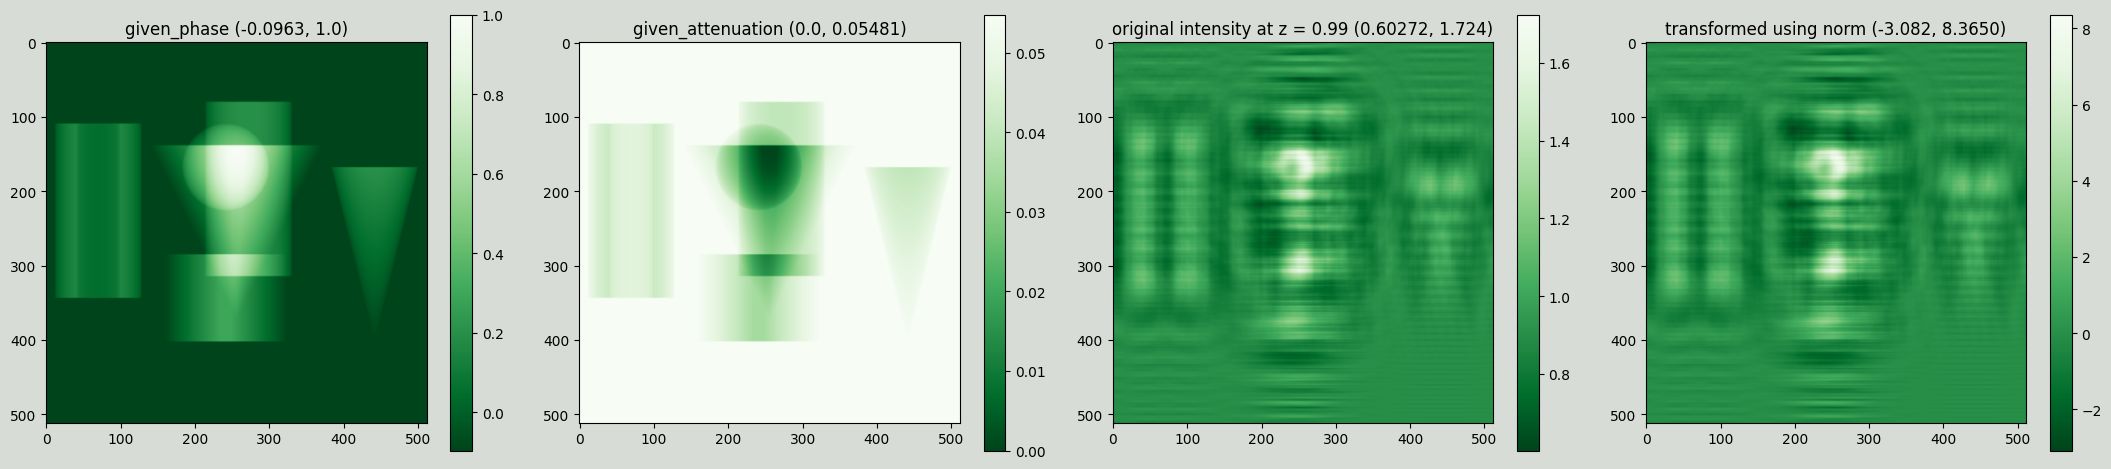

In [160]:
abs_ratio = 0.05
info = {
    'exp_name': 'heterogenous data',
    'phase': given_phase,
    'attenuation': (1 - given_absorption)*abs_ratio,
    'pv': pv.magnitude,
    'wavenumber': 2 * np.pi / lam.magnitude,
    'distance_sample_detector': z.magnitude,
    'fresnel_number': fresnel_number.magnitude,
    'lam': lam.magnitude,
    'energy_kev': energy.magnitude,
    'z': different_distances[z_id]*10,
    'pad':2,
    'idx': list(np.arange(0, len(different_distances), len(different_distances)//6)),
    'transform_factor': 0.7,
    'transform_type': 'norm',
    'mode': 'reflect',
    'value': 'mean',
    'abs_ratio': abs_ratio,
}
dataloader = Ganrec_Dataloader(**info)
fig = visualize([dataloader.phase, dataloader.attenuation, dataloader.image, tensor_to_np(dataloader.transformed_images)], title = ['given_phase', 'given_attenuation', 'original intensity at z = '+str(different_distances[z_id]), 'transformed using '+str(dataloader.transform_type)], cmap='Greens_r')

# Training process can be done easily using the make_ganrec class. 
### It's possible to update the dataloader with different setups

reshape
gen_loss:  tensor(1.2084, device='cuda:3', grad_fn=<AddBackward0>) dis_loss:  tensor(1.5090, device='cuda:3', grad_fn=<AddBackward0>) main_diff:  tensor(0.0652, device='cuda:3', grad_fn=<MeanBackward0>)
gen_loss:  tensor(0.9485, device='cuda:3', grad_fn=<AddBackward0>) dis_loss:  tensor(1.4245, device='cuda:3', grad_fn=<AddBackward0>) main_diff:  tensor(0.0365, device='cuda:3', grad_fn=<MeanBackward0>)
gen_loss:  tensor(0.8555, device='cuda:3', grad_fn=<AddBackward0>) dis_loss:  tensor(1.4068, device='cuda:3', grad_fn=<AddBackward0>) main_diff:  tensor(0.0276, device='cuda:3', grad_fn=<MeanBackward0>)
gen_loss:  tensor(0.8152, device='cuda:3', grad_fn=<AddBackward0>) dis_loss:  tensor(1.3742, device='cuda:3', grad_fn=<AddBackward0>) main_diff:  tensor(0.0226, device='cuda:3', grad_fn=<MeanBackward0>)
gen_loss:  tensor(0.7961, device='cuda:3', grad_fn=<AddBackward0>) dis_loss:  tensor(1.3440, device='cuda:3', grad_fn=<AddBackward0>) main_diff:  tensor(0.0195, device='cuda:3', gr

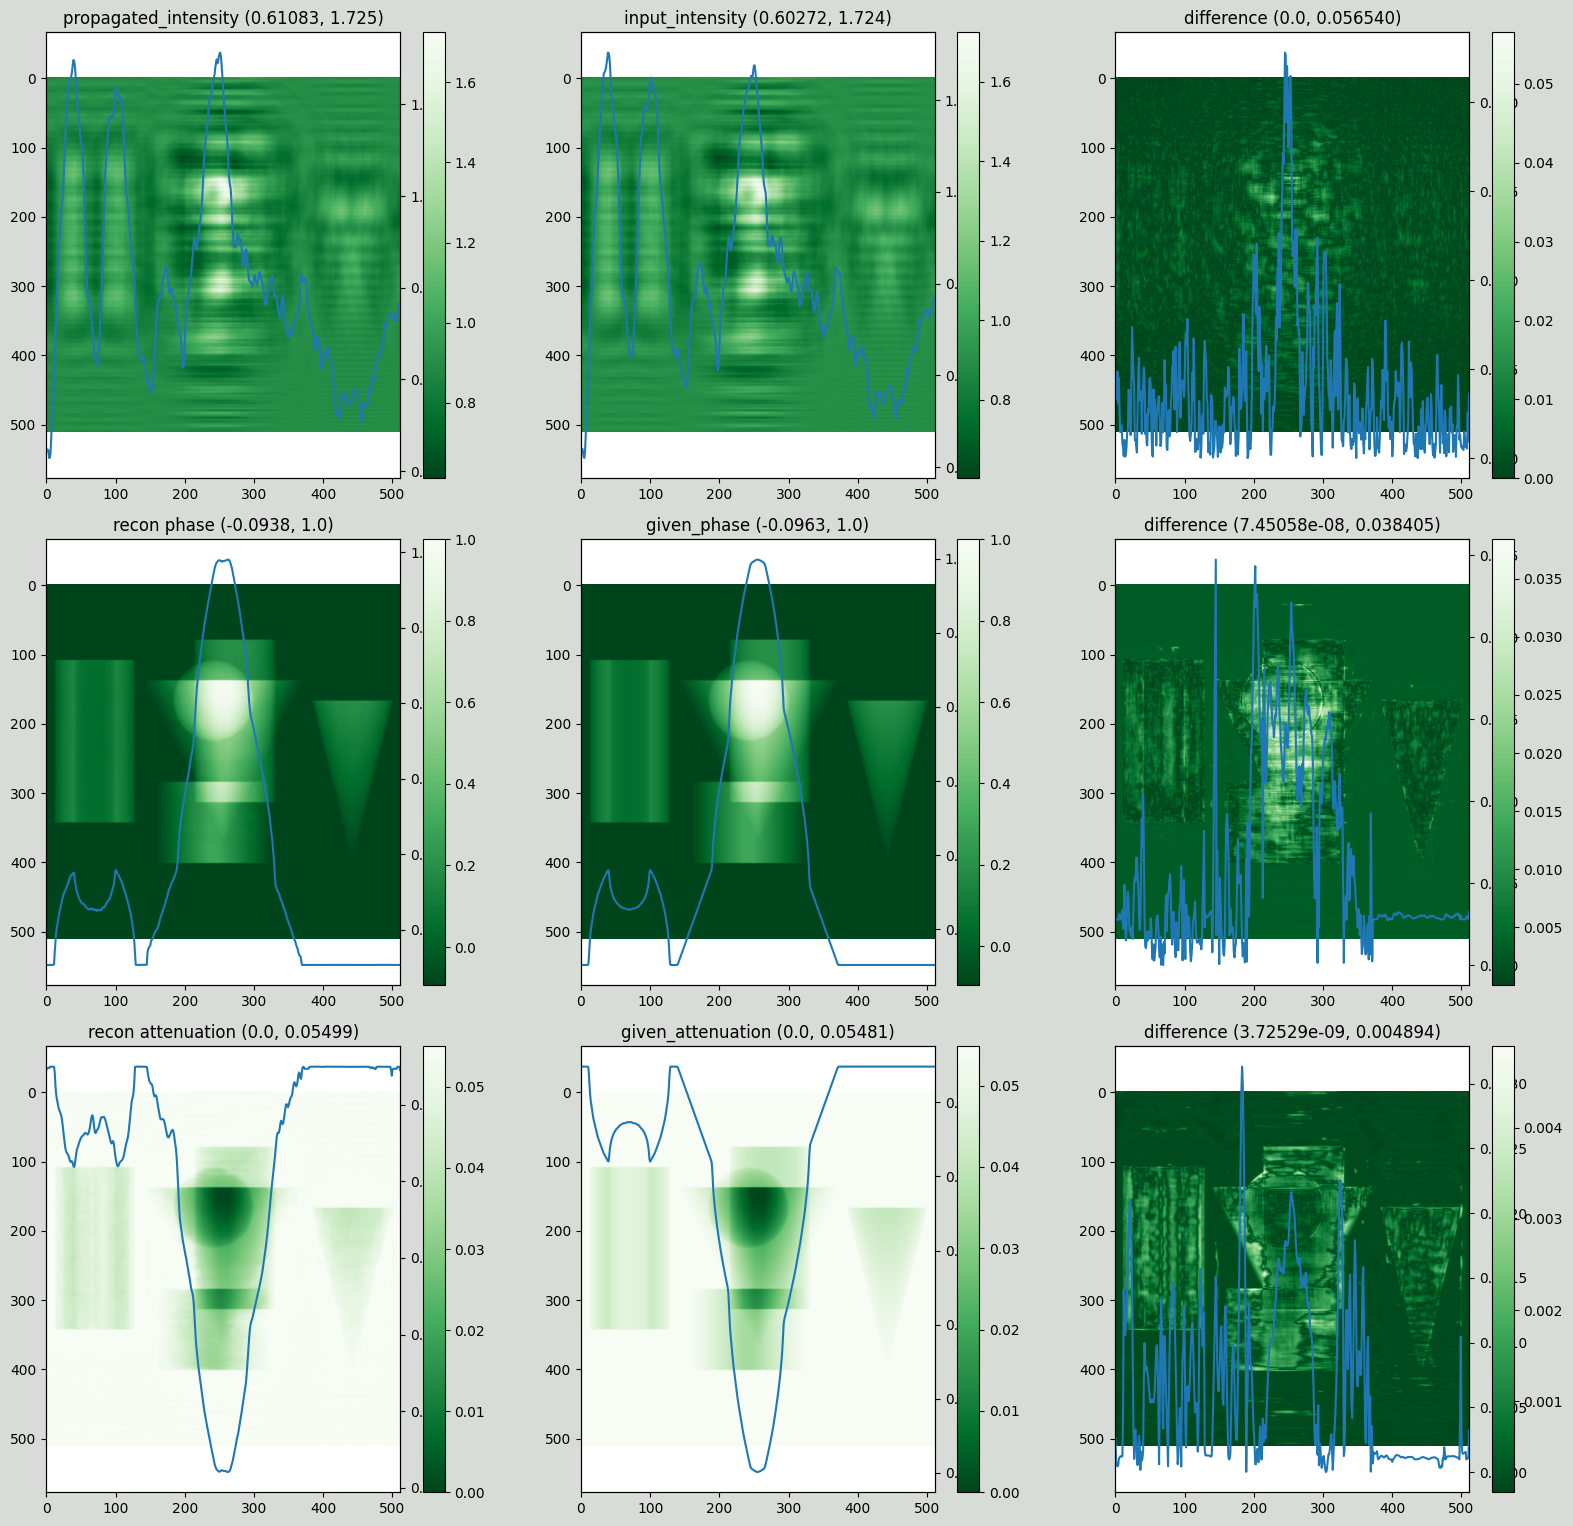

In [171]:
ratios = {'l1_ratio': 10, 'contrast_ratio': 0, 'normalized_ratio': 0, 'brightness_ratio': 0.0, 'contrast_normalize_ratio': 0.00, 'brightness_normalize_ratio': 0}

dataloader.update_values(iter_num = 10000, change_all=True, transform_type = 'reshape', transform_factor = 0.2, idx = 0, abs_ratio = 0.05)
model = make_ganrec_model(**dataloader.get_kwargs())
gen_loss_list, dis_loss_list, propagated_intensity_list, phase_list, attenuation_list = model.train(save_model=True, save_model_path='model.pth', **ratios)
fig = visualize([propagated_intensity_list[-1], tensor_to_np(dataloader.transformed_images), np.abs(tensor_to_np(dataloader.transformed_images) - propagated_intensity_list[-1]), phase_list[-1], dataloader.phase, np.abs(phase_list[-1] - dataloader.phase), attenuation_list[-1], dataloader.attenuation, np.abs(attenuation_list[-1] - dataloader.attenuation)], cmap = 'Greens_r', show_or_plot='both', plot_axis = 140, title = ['propagated_intensity', 'input_intensity', "difference", 'recon phase', 'given_phase', "difference",  'recon attenuation', 'given_attenuation', "difference"], rows =3, cols =3)

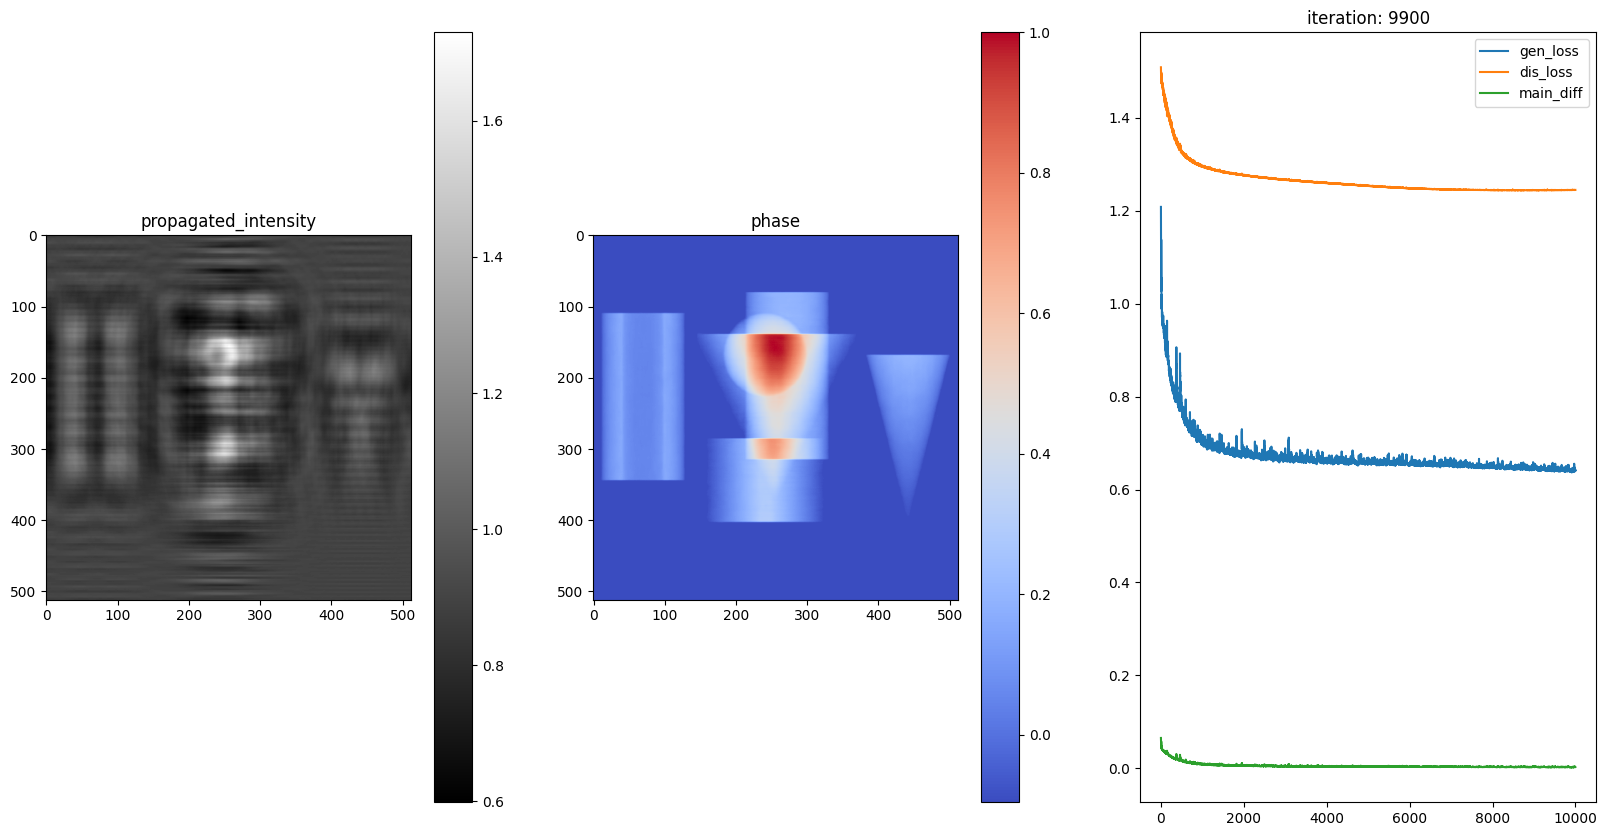

In [173]:
model.live_plot(rate = 100)